In [172]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from yahooquery import Ticker
data = yf.download(tickers='GOOGL', start='2015-03-02', end='2025-03-02', actions=True)
data.tail(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,Dividends,High,Low,Open,Stock Splits,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,,
2025-02-14,185.229996,0.0,186.399994,184.320007,185.059998,0.0,20448400
2025-02-18,183.770004,0.0,185.960007,181.740005,185.600006,0.0,29916700
2025-02-19,185.270004,0.0,185.460007,183.589996,184.070007,0.0,19549400
2025-02-20,184.559998,0.0,185.309998,182.720001,184.800003,0.0,20441500
2025-02-21,179.660004,0.0,185.339996,179.080002,185.149994,0.0,35199200
2025-02-24,179.250000,0.0,183.119995,178.889999,181.990005,0.0,29854200
2025-02-25,175.419998,0.0,178.740005,174.690002,178.039993,0.0,41913400
2025-02-26,172.729996,0.0,176.080002,171.580002,175.070007,0.0,35431300


In [174]:
import yfinance as yf

ticker = yf.Ticker('NVDA')
fundamentals = ticker.financials
print(fundamentals)


                                                        2025-01-31  \
Tax Effect Of Unusual Items                                    0.0   
Tax Rate For Calcs                                           0.133   
Normalized EBITDA                                    86137000000.0   
Total Unusual Items                                            0.0   
Total Unusual Items Excluding Goodwill                         0.0   
Net Income From Continuing Operation Net Minori...   72880000000.0   
Reconciled Depreciation                               1864000000.0   
Reconciled Cost Of Revenue                           32639000000.0   
EBITDA                                               86137000000.0   
EBIT                                                 84273000000.0   
Net Interest Income                                   1539000000.0   
Interest Expense                                       247000000.0   
Interest Income                                       1786000000.0   
Normalized Income   

In [176]:
print(data.columns)  

MultiIndex([(       'Close', 'GOOGL'),
            (   'Dividends', 'GOOGL'),
            (        'High', 'GOOGL'),
            (         'Low', 'GOOGL'),
            (        'Open', 'GOOGL'),
            ('Stock Splits', 'GOOGL'),
            (      'Volume', 'GOOGL')],
           names=['Price', 'Ticker'])


In [178]:
adj_close_col = ('Adj Close', 'GOOGL') if ('Adj Close', 'GOOGL') in data.columns else ('Close', 'GOOGL')
high_col = ('High', 'GOOGL')
low_col = ('Low', 'GOOGL')
open_col = ('Open', 'GOOGL')

print("Eksik değerlerin sayısı:", data[adj_close_col].isnull().sum())
data.dropna(subset=[adj_close_col], inplace=True)

# RSI (Relative Strength Index)
data[('RSI', 'GOOGL')] = ta.momentum.rsi(data[('Close', 'GOOGL')], window=15)

# EMA (Exponential Moving Average)
data['EMAF'] = ta.ema(data[adj_close_col], length=20)
data['EMAM'] = ta.ema(data[adj_close_col], length=50)
data['EMAS'] = ta.ema(data[adj_close_col], length=100)

# MACD (Moving Average Convergence Divergence)
macd = ta.macd(data[adj_close_col], fast=12, slow=26, signal=9)   
if macd is not None:   
    data['MACD'] = macd['MACD_12_26_9']  
    data['MACD_Signal'] = macd['MACDs_12_26_9'] 
else:
    # Alternatif MACD hesaplama
    data['EMA_12'] = data[adj_close_col].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data[adj_close_col].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Stokastik Osilatör 
stoch = ta.momentum.stoch(data[high_col], data[low_col], data[adj_close_col], window=14, smooth_window=3)
if stoch is not None:   
    data['Stoch_K'] = stoch['STOCHk_14_3_3']   
    data['Stoch_D'] = stoch['STOCHd_14_3_3']   
else:
    raise ValueError("Stokastik Osilatör hesaplanamadı. Veri veya parametreler hatalı olabilir.")

# Bollinger Bands
bbands = ta.bbands(data[adj_close_col], length=20, std=2)
if bbands is not None:   
    data['Bollinger_High'] = bbands['BBU_20_2.0']   
    data['Bollinger_Mid'] = bbands['BBM_20_2.0']   
    data['Bollinger_Low'] = bbands['BBL_20_2.0']   
else:
    raise ValueError("Bollinger Bands hesaplanamadı. Veri veya parametreler hatalı olabilir.")

# ATR (Average True Range) - Volatilite ölçer
data['ATR'] = ta.atr(data[high_col], data[low_col], data[adj_close_col], window=14)

# CCI (Commodity Channel Index) - Trend dönüşleri için
data['CCI'] = ta.cci(data[high_col], data[low_col], data[adj_close_col], length=20)
# Momentum
data['Momentum'] = ta.momentum.roc(data[adj_close_col], window=10)

# Williams %R - Aşırı alım / aşırı satım göstergesi
data['Williams_%R'] = ta.willr(data[high_col], data[low_col], data[adj_close_col], length=14)

# ADX (Average Directional Index) - Trendin gücünü belirler
adx = ta.adx(data[high_col], data[low_col], data[adj_close_col], length=14)
if adx is not None:
    data['ADX'] = adx['ADX_14']

# VWAP (Volume Weighted Average Price)
data['VWAP'] = ta.vwap(data[high_col], data[low_col], data[adj_close_col], data[('Volume', 'GOOGL')])

# OBV (On-Balance Volume)
data['OBV'] = ta.obv(data[adj_close_col], data[('Volume', 'GOOGL')])

# PSAR (Parabolic Stop and Reverse)
psar = ta.psar(data[high_col], data[low_col], data[adj_close_col])
data['PSAR'] = psar['PSARl_0.02_0.2']

# NVDA için temel analiz verilerini çek
ticker = Ticker('GOOGL')
fundamentals = ticker.financial_data

# NVDA için temel analiz verilerini çek
ticker = Ticker('GOOGL')
fundamentals = ticker.financial_data

if 'GOOGL' in fundamentals:
    stock_fundamentals = fundamentals['GOOGL']
    print(stock_fundamentals.keys())   

    # Temel analiz verilerini al
    data['Current_Price'] = stock_fundamentals.get('currentPrice')
    data['Target_High_Price'] = stock_fundamentals.get('targetHighPrice')
    data['Target_Low_Price'] = stock_fundamentals.get('targetLowPrice')
    data['Target_Mean_Price'] = stock_fundamentals.get('targetMeanPrice')
    data['Target_Median_Price'] = stock_fundamentals.get('targetMedianPrice')
    data['Recommendation_Mean'] = stock_fundamentals.get('recommendationMean')
    data['Number_Of_Analyst_Opinions'] = stock_fundamentals.get('numberOfAnalystOpinions')
    data['Total_Cash'] = stock_fundamentals.get('totalCash')
    data['Total_Cash_Per_Share'] = stock_fundamentals.get('totalCashPerShare')
    data['EBITDA'] = stock_fundamentals.get('ebitda')
    data['Total_Debt'] = stock_fundamentals.get('totalDebt')
    data['Quick_Ratio'] = stock_fundamentals.get('quickRatio')
    data['Current_Ratio'] = stock_fundamentals.get('currentRatio')
    data['Total_Revenue'] = stock_fundamentals.get('totalRevenue')
    data['Debt_To_Equity'] = stock_fundamentals.get('debtToEquity')
    data['Revenue_Per_Share'] = stock_fundamentals.get('revenuePerShare')
    data['Return_On_Assets'] = stock_fundamentals.get('returnOnAssets')
    data['Return_On_Equity'] = stock_fundamentals.get('returnOnEquity')
    data['Gross_Profits'] = stock_fundamentals.get('grossProfits')
    data['Free_Cashflow'] = stock_fundamentals.get('freeCashflow')
    data['Operating_Cashflow'] = stock_fundamentals.get('operatingCashflow')
    data['Earnings_Growth'] = stock_fundamentals.get('earningsGrowth')
    data['Revenue_Growth'] = stock_fundamentals.get('revenueGrowth')
    data['Gross_Margins'] = stock_fundamentals.get('grossMargins')
    data['EBITDA_Margins'] = stock_fundamentals.get('ebitdaMargins')
    data['Operating_Margins'] = stock_fundamentals.get('operatingMargins')
    data['Profit_Margins'] = stock_fundamentals.get('profitMargins')


# Fiyat bilgileri
data['Price'] = data[adj_close_col]
data['Dividends'] = data[('Dividends', 'GOOGL')]
data['High'] = data[high_col]
data['Low'] = data[low_col]
data['Open'] = data[open_col]
data['Stock Splits'] = data[('Stock Splits', 'GOOGL')]

# Hedef değişkenler
data['Target'] = data[('Close', 'GOOGL')] - data[open_col]
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data[('Close', 'GOOGL')].shift(-1)

# Eksik verileri kaldır
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop([('Volume', 'GOOGL'), ('Close', 'GOOGL'), 'Date'], axis=1, inplace=True)



Eksik değerlerin sayısı: 0
dict_keys(['maxAge', 'currentPrice', 'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 'targetMedianPrice', 'recommendationMean', 'recommendationKey', 'numberOfAnalystOpinions', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt', 'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 'returnOnAssets', 'returnOnEquity', 'grossProfits', 'freeCashflow', 'operatingCashflow', 'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 'operatingMargins', 'profitMargins', 'financialCurrency'])


C:\Users\omerf\AppData\Local\Temp\ipykernel_5448\482567149.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
C:\Users\omerf\AppData\Local\Temp\ipykernel_5448\482567149.py:134: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data.drop([('Volume', 'GOOGL'), ('Close', 'GOOGL'), 'Date'], axis=1, inplace=True)


In [179]:
print(data.columns)  

MultiIndex([(                 'Dividends', 'GOOGL'),
            (                      'High', 'GOOGL'),
            (                       'Low', 'GOOGL'),
            (                      'Open', 'GOOGL'),
            (              'Stock Splits', 'GOOGL'),
            (                       'RSI', 'GOOGL'),
            (                      'EMAF',      ''),
            (                      'EMAM',      ''),
            (                      'EMAS',      ''),
            (                      'MACD',      ''),
            (               'MACD_Signal',      ''),
            (                   'Stoch_K',      ''),
            (                   'Stoch_D',      ''),
            (            'Bollinger_High',      ''),
            (             'Bollinger_Mid',      ''),
            (             'Bollinger_Low',      ''),
            (                       'ATR',      ''),
            (                       'CCI',      ''),
            (                  'Momentum',    

In [170]:
import pandas as pd
from IPython.display import display


data.reset_index(inplace=True)

print("İlk 10 satır:")
display(data.head(10))

print("\nSon 5 satır:")
display(data.tail(5))

print("\nEksik veri sayısı:")
print(data.isnull().sum())

print("\nTeknik göstergelerin ilk 10 satırı:")
display(data[['Date', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'MACD', 'MACD_Signal', 'Stoch_K', 'Stoch_D', 'ATR', 'CCI', 'Momentum', 'Williams_%R', 'ADX']].head(10))

print("\nHedef değişkenlerin ilk 10 satırı:")
display(data[['Date', 'Target', 'TargetClass', 'TargetNextClose']].head(10))


İlk 10 satır:


Price,index,Dividends,High,Low,Open,Stock Splits,Price,RSI,EMAF,EMAM,...,Operating_Cashflow,Earnings_Growth,Revenue_Growth,Gross_Margins,EBITDA_Margins,Operating_Margins,Profit_Margins,Target,TargetClass,TargetNextClose
Ticker,,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,,,...,,,,,,,,,,
0,0,0.0,35.537674,34.456096,34.575661,0.0,34.629467,85.316158,30.175979,28.726958,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,-0.852907,0,33.614643
1,1,0.0,34.677790,33.458209,34.467550,0.0,33.614643,74.693195,30.503471,28.918632,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,-1.096029,0,32.620251
2,2,0.0,33.767094,32.541040,33.716280,0.0,32.620251,66.018896,30.705069,29.063794,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,0.333793,1,32.794617
3,3,0.0,33.233026,32.459828,32.460824,0.0,32.794617,66.748116,30.904073,29.210100,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,-0.104620,0,32.863865
4,4,0.0,33.085063,32.552494,32.968485,0.0,32.863865,67.050529,31.090720,29.353385,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,-0.041350,0,32.952045
5,5,0.0,35.072858,34.092411,34.852656,0.0,34.390331,70.156214,32.497587,30.643179,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,-0.150452,0,34.448624
6,6,0.0,34.674303,33.902603,34.599075,0.0,34.448624,70.439653,32.683400,30.792413,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,-0.134013,0,34.201519
7,7,0.0,34.576160,33.985802,34.335532,0.0,34.201519,67.512513,32.827983,30.926103,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,0.265536,1,34.343998
8,8,0.0,34.487977,34.021669,34.078462,0.0,34.343998,68.329721,32.972365,31.060138,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,0.302405,1,34.580143



Son 5 satır:


Price,index,Dividends,High,Low,Open,Stock Splits,Price,RSI,EMAF,EMAM,...,Operating_Cashflow,Earnings_Growth,Revenue_Growth,Gross_Margins,EBITDA_Margins,Operating_Margins,Profit_Margins,Target,TargetClass,TargetNextClose
Ticker,,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,,,...,,,,,,,,,,
1391,1391,0.0,196.789993,193.429993,195.559998,0.0,195.410004,54.288016,193.981648,187.632970,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,2.869995,1,200.869995
1392,1392,0.0,201.399994,197.669998,198.000000,0.0,200.869995,60.686813,194.637681,188.152069,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,2.020004,1,204.020004
1393,1393,0.0,205.479996,201.800003,202.000000,0.0,204.020004,63.832339,195.531236,188.774341,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,0.539993,1,201.229996
1394,1394,0.0,203.750000,200.100006,200.690002,0.0,201.229996,59.306146,196.073975,189.262798,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,2.990005,1,206.380005
1395,1395,0.0,207.050003,202.809998,203.389999,0.0,206.380005,64.333505,197.055502,189.934061,...,125298999296,0.309,0.118,0.582,0.36997,0.33967,0.28604,0.259995,1,191.330002



Eksik veri sayısı:
Price                       Ticker
index                                 0
Dividends                   GOOGL     0
High                        GOOGL     0
Low                         GOOGL     0
Open                        GOOGL     0
Stock Splits                GOOGL     0
Price                       GOOGL     0
RSI                         GOOGL     0
EMAF                                  0
EMAM                                  0
EMAS                                  0
MACD                                  0
MACD_Signal                           0
Stoch_K                               0
Stoch_D                               0
Bollinger_High                        0
Bollinger_Mid                         0
Bollinger_Low                         0
ATR                                   0
CCI                                   0
Momentum                              0
Williams_%R                           0
ADX                                   0
VWAP                     

KeyError: "['Date' 'RSI' 'EMAF' 'EMAM' 'EMAS' 'MACD' 'MACD_Signal' 'Stoch_K'\n 'Stoch_D' 'ATR' 'CCI' 'Momentum' 'Williams_%R' 'ADX'] not in index"

In [182]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data)
print(data_set_scaled)

[[0.         0.01640243 0.0151432  ... 0.35287398 0.         0.01434778]
 [0.         0.01147112 0.00930565 ... 0.33849656 0.         0.00867463]
 [0.         0.00624842 0.00394028 ... 0.42305137 1.         0.00966941]
 ...
 [0.         0.99099624 0.99409161 ... 0.43524536 1.         0.97061843]
 [0.         0.98107498 0.98414677 ... 0.58013073 1.         1.        ]
 [0.         1.         1.         ... 0.41868718 1.         0.91413748]]


In [184]:
import numpy as np

X = []
backcandles = 30
print(data_set_scaled.shape[0])

for j in range(30): 
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

# Ekseni taşıma
X = np.moveaxis(X, [0], [2])

# Hedef değişkenleri hazırlama
X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -3])
y = np.reshape(yi, (len(yi), 1))

# Eğitim ve test setlerine ayırma
splitlimit = int(len(X) * 0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print(X.shape)  # (num_samples, backcandles, num_features)
print(y.shape)  


1396
(1366, 30, 30)
(1366, 1)


In [188]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit],X[splitlimit:]
y_train, y_test = y[:splitlimit],y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1092
(1092, 30, 30)
(274, 30, 30)
(1092, 1)
(274, 1)
[[0.40307621]
 [0.42084162]
 [0.35060533]
 ...
 [0.42982761]
 [0.27603811]
 [0.32023036]]


In [192]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.random.seed(10)

# LSTM modeli
lstm_input = Input(shape=(backcandles, 30), name='lstm_input')
inputs = LSTM(150, return_sequences=True, name='first_layer', dropout=0.2, recurrent_dropout=0.2)(lstm_input)
inputs = LSTM(100, name='second_layer')(inputs)
inputs = Dense(32, name='dense_layer')(inputs)
output = Dense(1, name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)

#compile
adam = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam, loss='mse')

model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.2)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2585 - val_loss: 0.0111
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - val_loss: 0.0133
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022 - val_loss: 0.0125
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021 - val_loss: 0.0153
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023 - val_loss: 0.0122
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0110
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 0.0113
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019 - val_loss: 0.0112
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023 - val_loss: 0.0124
Epoch 12/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

In [194]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43,1,0)
for i in range(10):
    print(y_pred[i],y_test[i])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[0.40566054] [0.35087057]
[0.4063985] [0.40213328]
[0.4071881] [0.58950842]
[0.4073235] [0.37149353]
[0.4065056] [0.33260414]
[0.4062394] [0.28900125]
[0.40652665] [0.49699979]
[0.40728804] [0.51997971]
[0.40708154] [0.48050097]
[0.40579376] [0.28605537]


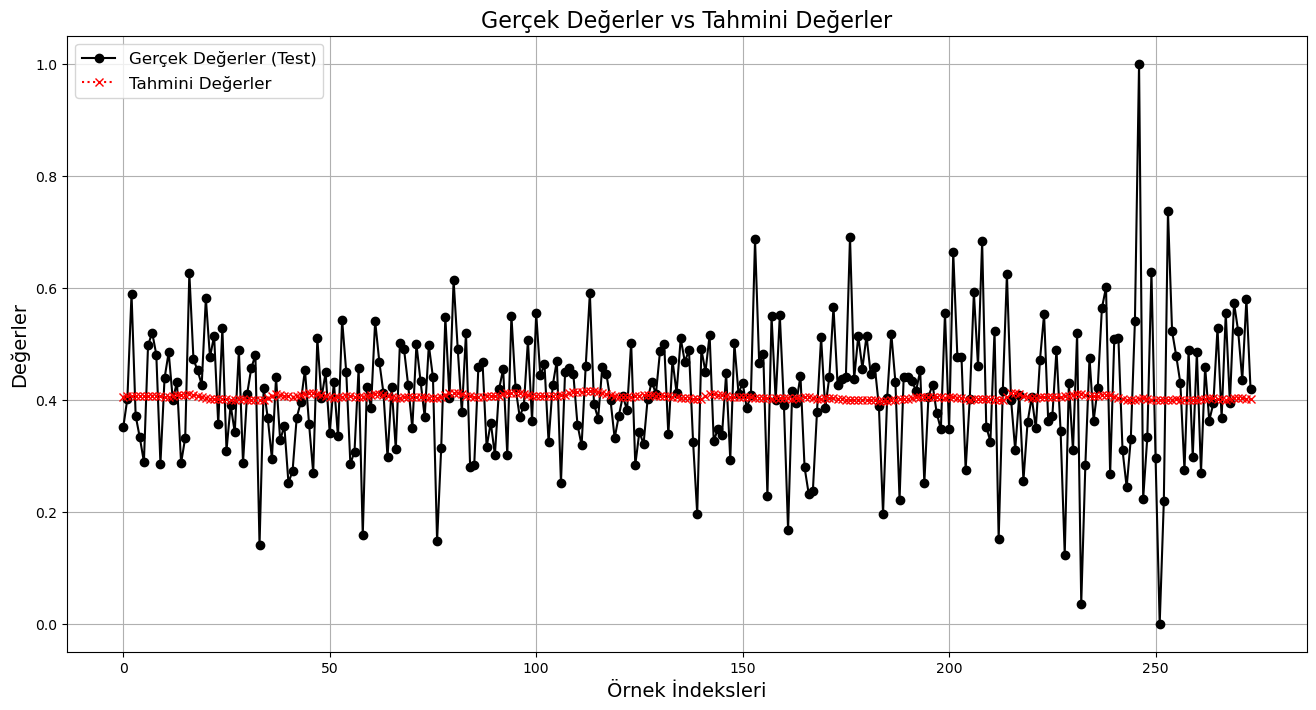

In [196]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

plt.plot(y_test, color='black', label='Gerçek Değerler (Test)', linestyle='-', marker='o')

plt.plot(y_pred, color='red', label='Tahmini Değerler', linestyle=':', marker='x')

plt.title('Gerçek Değerler vs Tahmini Değerler', fontsize=16) 
plt.xlabel('Örnek İndeksleri', fontsize=14)  
plt.ylabel('Değerler', fontsize=14)  
plt.legend(fontsize=12)  
plt.grid(True)  
plt.show()

In [198]:
#Performans Ölçütleri
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Modelin Performans Ölçütleri")
y_pred = model.predict(X_test)

y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

from sklearn.metrics import median_absolute_error

medae = median_absolute_error(y_true, y_pred)
print(f"Median Absolute Error (MedAE): {medae:.2f}")

from sklearn.metrics import explained_variance_score

explained_variance = explained_variance_score(y_true, y_pred)
print(f"Explained Variance Score: {explained_variance:.2f}")



Modelin Performans Ölçütleri
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Absolute Error (MAE): 0.09
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.12
R-squared (R²): -0.01
Mean Absolute Percentage Error (MAPE): inf%
Median Absolute Error (MedAE): 0.07
Explained Variance Score: -0.00


C:\Users\omerf\AppData\Local\Temp\ipykernel_5448\3706696948.py:27: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
